In [44]:
import os, json, numpy as np, networkx as nx, scipy.signal as sg, scipy.stats as ss
import matplotlib.pyplot as plt, seaborn as sns
from whobpyt.data_loader import BOLDDataLoader, DEVICE
from whobpyt.utils.fc_tools import bold_to_fc           
plt.rcParams.update({"savefig.dpi":300, "font.size":8})
sns.set_style("whitegrid")

In [42]:
DATA_ROOT = "/vol/bitbucket/ank121/fyp/HCP Data"
FIG_DIR   = "/vol/bitbucket/ank121/whobpyt/plots/intro"; os.makedirs(FIG_DIR, exist_ok=True)
SUBJ      = 18

loader = BOLDDataLoader(f"{DATA_ROOT}/BOLD Timeseries HCP.mat",
                        f"{DATA_ROOT}/distance_matrices",
                        f"{DATA_ROOT}/schaefer100_dist.npy")
ts_emp   = loader.all_bold[SUBJ]            # (N,T)
fc_emp   = bold_to_fc(ts_emp)               # (N,N)
N,T      = ts_emp.shape
tri      = np.tril_indices(N,-1)

[DataLoader] Loaded 100 subjects.


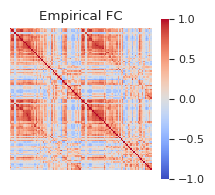

In [53]:
plt.figure(figsize=(2.2,2))
sns.heatmap(fc_emp, vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=True)
plt.title("Empirical FC")
plt.axis("off")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/INTRO_FC.png"); plt.close()
# plt.show()


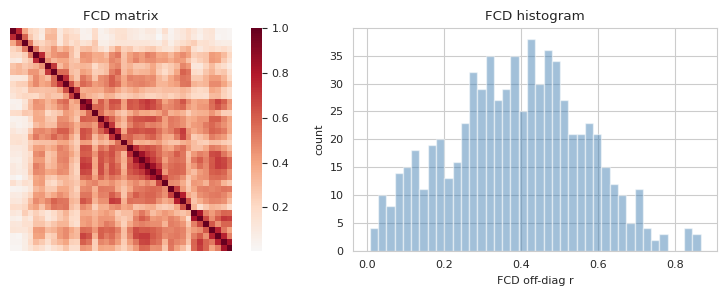

In [72]:
def fcd_matrix(ts, win=60, step=30):
    vecs = []
    for s in range(0, T-win+1, step):
        vecs.append(bold_to_fc(ts[:,s:s+win])[tri])
    vecs = np.stack(vecs); return np.corrcoef(vecs)
F_emp = fcd_matrix(ts_emp)

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1); sns.heatmap(F_emp, cmap="RdBu_r", center=0, cbar=True, square=True)
plt.title("FCD matrix"); plt.axis("off")
plt.subplot(1,2,2); plt.hist(F_emp[np.triu_indices_from(F_emp,1)],
                              bins=40, alpha=.5, color="steelblue")
# plt.hist(F_rand[np.triu_indices_from(F_emp,1)], bins=40, alpha=.5)
                              
plt.xlabel("FCD off-diag r"); plt.ylabel("count")
ks_emp = ss.ks_2samp(F_emp[np.triu_indices_from(F_emp,1)], np.random.randn(1000)).statistic
plt.title(f"FCD histogram")
plt.tight_layout(); #plt.savefig(f"{FIG_DIR}/INTRO_FCD.png"); plt.close()
plt.show()


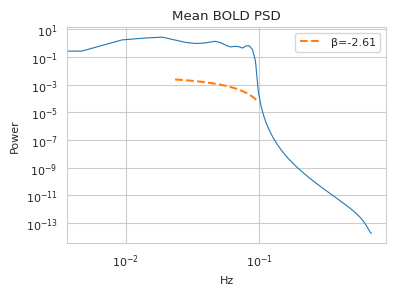

In [73]:
def spectral_slope(ts, fs=1/0.72, f_lo=0.02, f_hi=0.1, title=None):
    """ Average PSD across regions, regress log-power on log-freq.
        Returns +β so 1/f^β 
    """
    N, T = ts.shape
    # Welch across entire run
    f, Pxx = sg.welch(ts, fs=fs, nperseg=T//4, axis=1)
    mask = (f >= f_lo) & (f <= f_hi)
    x = np.log(f[mask]); y = np.log(Pxx[:, mask].mean(axis=0))
    beta, _ = np.polyfit(x, y, 1)
    plt.figure(figsize=(4,3))
    plt.loglog(f, Pxx.mean(0), linewidth=.8)
    plt.loglog(f[mask], np.exp(-beta*x[::-1]), '--', label=f"β={beta:.2f}")
    plt.xlabel("Hz"); plt.ylabel("Power"); plt.legend(); plt.title(f"Mean BOLD PSD")
    plt.tight_layout(); #plt.savefig(f"{FIG_DIR}/INTRO_Beta.png"); plt.close()
    plt.show()
    return -beta      # make positive

beta_emp = spectral_slope(ts_emp, title="Empirical")

In [ ]:
def fc_vecs(ts, win=60):
    return np.stack([bold_to_fc(ts[:,i:i+win])[tri] for i in range(0,T-win+1,win)])
vecs  = fc_vecs(ts_emp, win=60)
from sklearn.cluster import KMeans
k     = 5
labels= KMeans(k, n_init=50, random_state=0).fit_predict(vecs)
dwell = np.bincount(labels,minlength=k)/len(labels)
P     = np.ones((k,k))
for a,b in zip(labels[:-1], labels[1:]): P[a,b]+=1
P     /= P.sum(1,keepdims=True)
fig,ax = plt.subplots(1,2,figsize=(4,2))
ax[0].bar(range(k), dwell, color="darkred"); ax[0].set_title("State dwell %"); ax[0].set_ylim(0,1)
sns.heatmap(P, vmin=0, vmax=P.max(), ax=ax[1]); ax[1].set_title("Transition matrix"); ax[1].axis("off")
plt.tight_layout(); #plt.savefig(f"{FIG_DIR}/INTRO_Dwell.png"); plt.close()
plt.show()


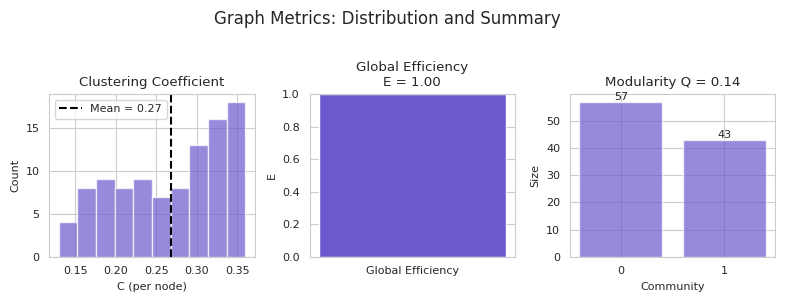

In [ ]:
# np.fill_diagonal(fc_emp, 0)
# A = np.abs(fc_emp)
# G = nx.from_numpy_array(A)

A = fc_emp.copy()
np.fill_diagonal(A,0)
A[A<0] = 0                 # *** keep sign information ***
G = nx.from_numpy_array(A)


# Compute metrics and their distributions
clustering_vals = np.array(list(nx.clustering(G, weight='weight').values()))
C_mean = clustering_vals.mean()
C_std = clustering_vals.std()

E = nx.global_efficiency(G)

communities = nx.algorithms.community.louvain_communities(G, weight='weight', seed=0)
Q = nx.algorithms.community.modularity(G, communities, weight='weight')
num_communities = len(communities)
community_sizes = [len(c) for c in communities]

# Plot with more informative labels and extra info
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

# Clustering coefficient: show distribution
axs[0].hist(clustering_vals, bins=10, color="slateblue", alpha=0.7)
axs[0].axvline(C_mean, color='k', linestyle='--', label=f"Mean = {C_mean:.2f}")
axs[0].set_title("Clustering Coefficient")
axs[0].set_xlabel("C (per node)")
axs[0].set_ylabel("Count")
axs[0].legend(fontsize=8)

# Global efficiency: just a value
axs[1].bar([0], [E], color="slateblue", width=0.01)
axs[1].set_xticks([0])
axs[1].set_xticklabels(["Global Efficiency"])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel("E")
axs[1].set_title(f"Global Efficiency\nE = {E:.2f}")

# Modularity: show value and community sizes
axs[2].bar(range(num_communities), community_sizes, color="slateblue", alpha=0.7)
axs[2].set_title(f"Modularity Q = {Q:.2f}")
axs[2].set_xlabel("Community")
axs[2].set_ylabel("Size")
for i, size in enumerate(community_sizes):
    axs[2].text(i, size + 0.2, str(size), ha='center', va='bottom', fontsize=8)
axs[2].set_xticks(range(num_communities))

plt.suptitle("Graph Metrics: Distribution and Summary", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(f"{FIG_DIR}/INTRO_Graph.png")
plt.show()


In [86]:
np.fill_diagonal(fc_emp,0); A=np.abs(fc_emp)
str_emp = A.sum(1)
plt.figure(figsize=(2.4,2))
plt.hist(str_emp,bins=15,color="teal",alpha=.7); plt.xlabel("node strength"); plt.ylabel("count")
plt.title("Strength distribution")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/INTRO_NodeStrength.png"); plt.close()
# plt.show()



In [87]:
def kuramoto_R(ts,band=(.04,.07)):
    b,a=sg.butter(3,np.array(band)/(fs/2),'band')
    phi=np.angle(sg.hilbert(sg.filtfilt(b,a,ts,axis=1)))
    return np.abs(np.exp(1j*phi).mean(0))
met = kuramoto_R(ts_emp).std()
plt.figure(figsize=(3,1.6)); plt.plot(kuramoto_R(ts_emp)); plt.title(f"Kuramoto R(t) σ={met:.3f}")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/INTRO_Meta.png"); plt.close()
# plt.show()
